# Libraries and references

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-903b171a149c>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# https://www.kaggle.com/pinardogan/time-series-using-lightgbm-with-explanations
# https://timeseriesreasoning.com/contents/regression-with-arima-errors-model/
# https://machinelearningmastery.com/model-residual-errors-correct-time-series-forecasts-python/
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

# Reading and initial analysis of data

In [3]:
data_df = pd.read_csv("train.csv")

In [4]:
data_df.head(5)
print(data_df.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [5]:
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df.sort_values("Date",inplace=True)
data_df["Year"] = data_df.Date.dt.year
data_df["Month"] = data_df.Date.dt.month_name()
data_df["Week"] = data_df.Date.dt.week
data_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week
1017208,1115,2,2013-01-01,0,0,0,0,a,1,2013,January,1
1016473,379,2,2013-01-01,0,0,0,0,a,1,2013,January,1
1016472,378,2,2013-01-01,0,0,0,0,a,1,2013,January,1
1016471,377,2,2013-01-01,0,0,0,0,a,1,2013,January,1
1016470,376,2,2013-01-01,0,0,0,0,a,1,2013,January,1


# Building ARIMA + LR model for store 5

In [6]:
df_Store = data_df[data_df.Store==5][["Date","Sales","Promo","StateHoliday","SchoolHoliday"]].reset_index().drop(columns="index")
df_Store.sort_values("Date",inplace=True)
df_Store.head(5)

,Date,Sales,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,0,0,a,1
1,2013-01-02,4253,0,0,1
2,2013-01-03,3465,0,0,0
3,2013-01-04,4456,0,0,0
4,2013-01-05,1590,0,0,0


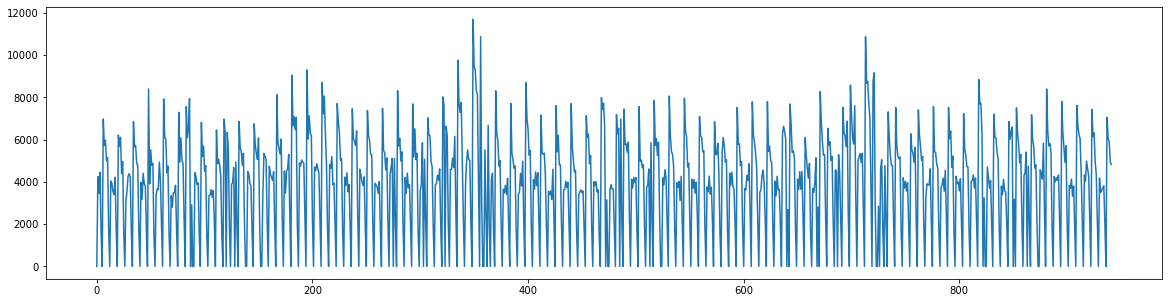

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df_Store["Sales"])
plt.show()

- Constant mean and SD throughout
- Signs of seasonality but not constant

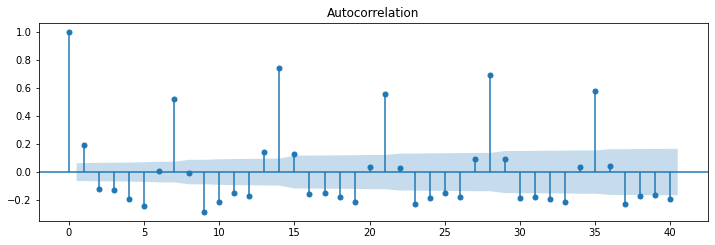

In [8]:
# Check for direct and indirect weekly seasonality 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(df_Store["Sales"],lags=40,ax=ax)

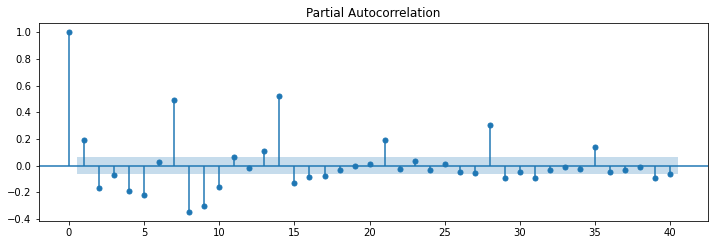

In [9]:
# Check for direct weekly seasonality 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_pacf(df_Store["Sales"],lags=40,ax=ax)

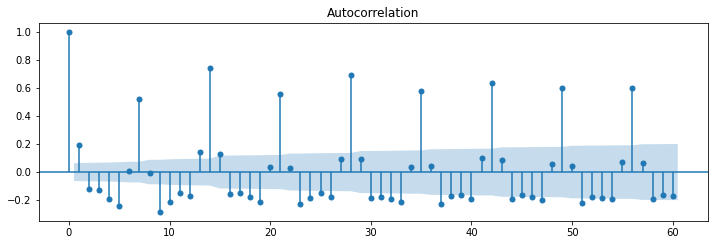

In [10]:
# Check for direct and indirect monthly seasonality 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(df_Store["Sales"],lags=60,ax=ax)

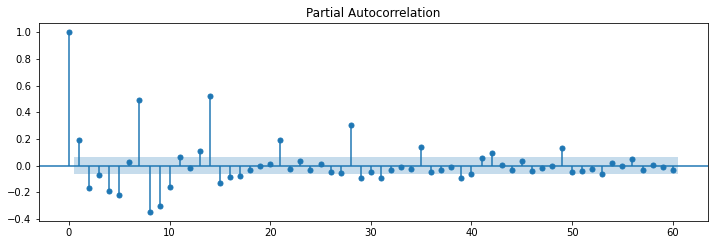

In [11]:
# Check for direct monthly seasonality 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_pacf(df_Store["Sales"],lags=60,ax=ax)

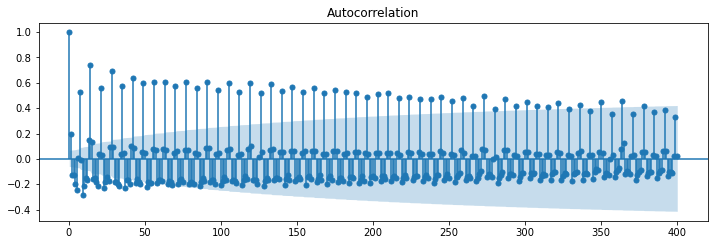

In [12]:
# Check for direct and indirect yearly seasonality 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(df_Store["Sales"],lags=400,ax=ax)

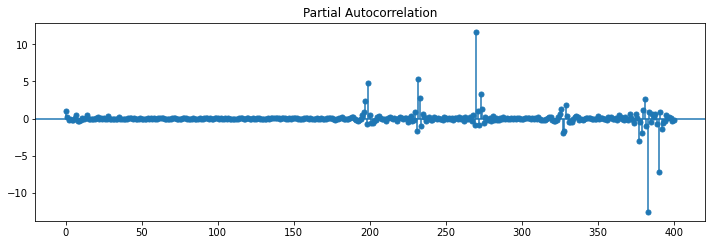

In [13]:
# Check for direct seasonality 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_pacf(df_Store["Sales"],lags=400,ax=ax)

## Splitting dataset into training and test subset

In [14]:
SalesSample = pd.DataFrame()
SalesSample["Sales"] = df_Store.Sales
SalesSample["Date"] = df_Store.Date
SalesSample["Promo"] = df_Store.Promo

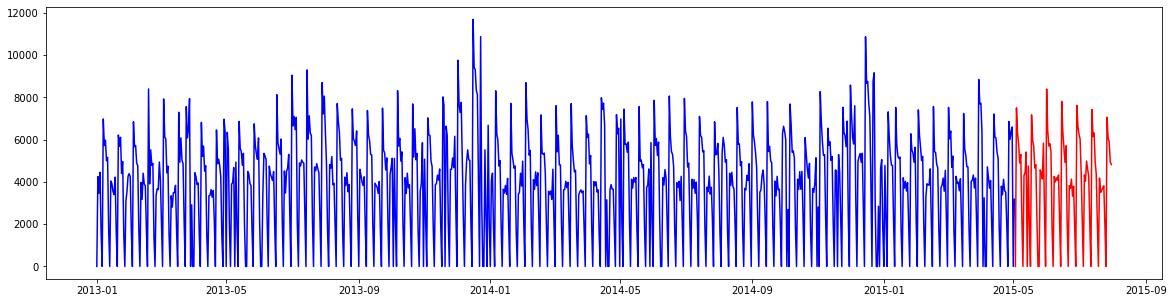

In [15]:
test_size = 90 # 3 months of data

train = SalesSample[:-test_size]
test = SalesSample[-test_size:]

plt.subplots(figsize=(20,5))

plt.plot(train['Date'], train['Sales'],color='blue', label='Train')
plt.plot(test['Date'], test['Sales'], color='red', label='Test')

# Training and testing
1. ARIMA model
2. Kernel (ARIMA) + LR

In [16]:
model = ARIMA(train["Sales"], order=(7,0,7), dates= train.Date)
model_fit = model.fit()

In [17]:
# Predicting on training data
start_index_train = datetime(2013,1,1)
end_index_train = datetime(2015,5,2)
forecast_train = model_fit.predict(start=start_index_train,end=end_index_train)

# Predicting on test data
start_index_test = datetime(2015,5,3)
end_index_test = datetime(2015,7,31)
forecast_test = model_fit.predict(start=start_index_test,end=end_index_test)

In [18]:
forecast_df_train = pd.DataFrame()
forecast_df_train["Date"] = forecast_train.index
forecast_df_train["Sales"] = forecast_train.values

forecast_df_test = pd.DataFrame()
forecast_df_test["Date"] = forecast_test.index
forecast_df_test["Sales"] = forecast_test.values

In [19]:
train.set_index("Date",inplace=True)
test.set_index("Date",inplace=True)

forecast_df_train.set_index("Date",inplace=True)
forecast_df_test.set_index("Date",inplace=True)

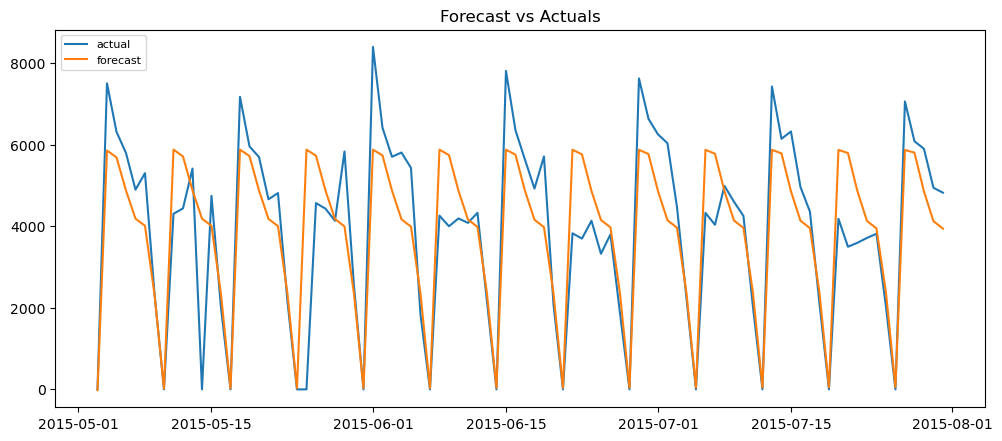

In [20]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test["Sales"], label='actual')
plt.plot(forecast_df_test["Sales"], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
print("R2 score using ARIMA only: ",r2_score(test["Sales"],forecast_df_test["Sales"]))

R2 score using ARIMA only:  0.6905087817375134


In [22]:
  
model = LinearRegression()
train["ARIMA_forecast"] = forecast_df_train["Sales"]
model.fit(train[["ARIMA_forecast","Promo"]],train["Sales"])

test["ARIMA_forecast"] = forecast_df_test["Sales"]
predict = model.predict(test[["ARIMA_forecast","Promo"]])


In [23]:
model.coef_

array([7.86726622e-01, 1.56406450e+03])

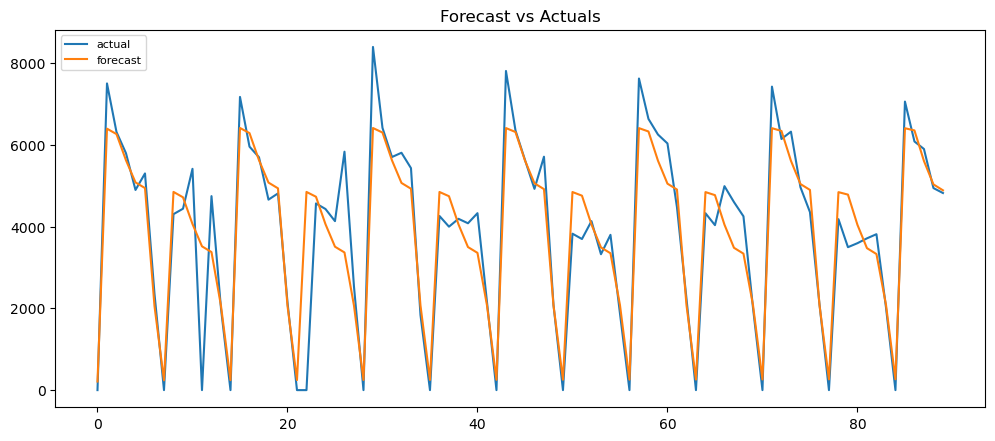

In [24]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test["Sales"].values, label='actual')
plt.plot(predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
print("R2 score using ARIMA and promo: ",r2_score(test["Sales"].values,predict))

R2 score using ARIMA and promo:  0.8404726777185367
